## Shapefile georeferencer

This notebook was designed to georefence a shapefile using a control point file with three dimensional coordinates. 

For now the notebook works with line shapefiles only, and uses a first order polynomial transformation for georeferencing. 

This notebook requires the Python modules numpy, scipy, geopandas, shapely and sympy.

## Import some Python modules

In [48]:
import numpy as np
import geopandas as gp
import scipy.optimize

import shapely
import sympy

## Some parameters for georeferencing

In [33]:
#geometry = 

# shapefile to be projected
shpfile = 'data/L48_1_MG_TM fractures.shp'

# file with control points, ie points for which the coordinates are known
control_pt_file = 'data/L48_1_MG coord locations.shp'

# columns in the control point file that designate real coordinates
cp_x_col = 'northing'
cp_y_col = 'easting'
cp_z_col = 'elevation'

# absolute and relative tolerance of optimization algorithm to find the georeference transofrmation
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
# feel free to adjust these values if the georeferencing error is too high
xtol = 1e-8
ftol = 1e-8

## Optional parameters for projecting the 3D georefenced shapefile/lines onto a 2D plane

In [45]:
# Switch to turn projection on or off
project_shapefile = True

# file with three points that define a plane
# if the file contains more than three pts then the first three are used only
plane_pt_file = 'data/L48_1_MG coord locations.shp'

# columns in the plane point file that designate real coordinates
pp_x_col = 'northing'
pp_y_col = 'easting'
pp_z_col = 'elevation'

## Read control point file

In [34]:
cp = gp.read_file(control_pt_file)
cp.head()

,id,northing,easting,elevation,geometry
0,1,5742957.092,3588783.315,486.818,POINT (2026.601 -2236.399)
1,2,5742950.091,3588784.181,489.146,POINT (3745.403 -1620.575)
2,3,5742961.891,3588784.179,491.471,POINT (594.475 -959.583)
3,4,5742955.344,3588784.760,491.381,POINT (2465.584 -1001.695)


In [35]:
src = np.array([g.coords[:][0] for g in cp.geometry])
dst = np.array(list(zip(cp[cp_x_col], cp[cp_y_col], cp[cp_z_col])))

print('source coords: ', src)
print('to be projected to: ', dst)

source coords:  [[ 2026.600641   -2236.39859409]
 [ 3745.40348893 -1620.57498587]
 [  594.47528058  -959.58308778]
 [ 2465.58406617 -1001.69516552]]
to be projected to:  [[5.74295709e+06 3.58878331e+06 4.86818000e+02]
 [5.74295009e+06 3.58878418e+06 4.89146000e+02]
 [5.74296189e+06 3.58878418e+06 4.91471000e+02]
 [5.74295534e+06 3.58878476e+06 4.91381000e+02]]


## Some functions to transform coordinates

In [36]:
def transform(params, x, y, order):
    
    if order == 1:
        ax, bx, cx, ay, by, cy, az, bz, cz = params
        x_transformed = ax * x + bx * y + cx
        y_transformed = ay * x + by * y + cy
        z_transformed = az * x + bz * y + cz 
        
    else:
        pass
        # 2nd order transform not implemented yet...
        
    return x_transformed, y_transformed, z_transformed


def get_transform_error(params, src, dst, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]
    
    x_dst = dst[:, 0]
    y_dst = dst[:, 1]
    z_dst = dst[:, 2]
    
    # transform the source coordinates
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    # check how far off the coordinates are from their real coords
    xd = x_dst - xt
    yd = y_dst - yt
    zd = z_dst - zt
    err = np.sqrt(xd**2 + yd**2 + zd**2)
    
    # calculate the RMSE and return this
    rmse = np.sqrt(np.mean((err)**2))
    
    #print(rmse)
    
    return rmse


def transform_func(params, src, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]
    
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    return np.vstack([xt, yt, zt]).T

## Run optimization algorithm to find transform for control points

In [37]:
cx_guess = dst[:, 0].mean() - src[:, 0].mean()
cy_guess = dst[:, 1].mean() - src[:, 1].mean()
cz_guess = dst[:, 2].mean()

#cx_guess = 1
#cy_guess = 1

# first guess transform params
order = 1
params = [1, 1, cx_guess, 1, 1, cy_guess, 0, 0, cz_guess]
#params = [1, 1, cx_guess, 1, 1, cy_guess]

print('first guess params ', params)


opt_results = scipy.optimize.fmin(get_transform_error, params, args=(src, dst, order), 
                                 maxiter=1e5, xtol=xtol, ftol=ftol, full_output=True)

params_opt = opt_results[0]
opt_error = opt_results[1]
#params_opt = scipy.optimize.fmin_cg(get_transform_error, params, args=(src, dst))

print('optimized params', params_opt)

first guess params  [1, 1, 5740748.088630828, 1, 1, 3590238.6717083165, 0, 0, 489.70399999999995]
Optimization terminated successfully.
         Current function value: 2.164650
         Iterations: 1966
         Function evaluations: 2973
optimized params [-3.78054589e-03 -2.49228296e-04  5.74296409e+06  2.29329504e-04
  1.04762319e-03  3.58878513e+06  1.37430915e-03  7.75896236e-03
  4.97961583e+02]


## Show georefencing results

In [38]:
print('the optimized equation for transformation is:')
print('x = %0.2e x + %0.2e y + %0.2e' % (params_opt[0], params_opt[1], params_opt[2]))
print('y = %0.2e x + %0.2e y + %0.2e' % (params_opt[3], params_opt[4], params_opt[5]))
print('z = %0.2e x + %0.2e y + %0.2e' % (params_opt[6], params_opt[7], params_opt[8]))
print('\nthe RMSE of the distance between the real coordinates and the transformed coords = %0.2e ' 
      %(opt_error))

srct = transform_func(params_opt, src, order)

print('the coordinates of the real and georeferenced control points are\n',srct, '\n\n', dst)

the optimized equation for transformation is:
x = -3.78e-03 x + -2.49e-04 y + 5.74e+06
y = 2.29e-04 x + 1.05e-03 y + 3.59e+06
z = 1.37e-03 x + 7.76e-03 y + 4.98e+02

the RMSE of the distance between the real coordinates and the transformed coords = 2.16e+00 
the coordinates of the real and georeferenced control points are
 [[5.74295699e+06 3.58878325e+06 4.83394626e+02]
 [5.74295033e+06 3.58878429e+06 4.90534945e+02]
 [5.74296208e+06 3.58878426e+06 4.91333206e+02]
 [5.74295502e+06 3.58878464e+06 4.93577942e+02]] 

 [[5.74295709e+06 3.58878331e+06 4.86818000e+02]
 [5.74295009e+06 3.58878418e+06 4.89146000e+02]
 [5.74296189e+06 3.58878418e+06 4.91471000e+02]
 [5.74295534e+06 3.58878476e+06 4.91381000e+02]]


## Load shapefile that should be projected

In [39]:
shp = gp.read_file(shpfile)
shp.head()

,geometry
0,"LINESTRING (518.362 -1139.601, 1464.451 -1400...."
1,"LINESTRING (1009.730 -1275.061, 987.286 -1395...."
2,"LINESTRING (623.263 -1319.963, 989.359 -1414.639)"
3,"LINESTRING (936.874 -1401.862, 944.354 -1494.726)"
4,"LINESTRING (539.561 -1413.767, 944.354 -1494.7..."


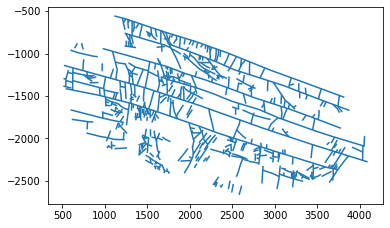

In [40]:
shp.plot()

## Project shapefile

In [41]:
gt = []

for g in shp.geometry:
    
    gc = np.array(g.coords[:])
    
    gct = transform_func(params_opt, gc, order)
    
    l = shapely.geometry.LineString(gct)
    
    gt.append(l)
    

In [108]:
gct.shape

(2, 3)

In [42]:
#shp['geometry_backup'] = shp.geometry
shp.geometry = gt

## Save georeferenced shapefile

In [43]:
fn_out = shpfile[:-4] + '_georef.shp'

print('saving georeferenced shapefile as\n\t%s' % fn_out)

shp.to_file(fn_out)

saving georeferenced shapefile as
	data/L48_1_MG_TM fractures_georef.shp


## Show the georeferenced shapefile

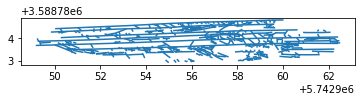

In [44]:
shp.plot()  

## Optional: Project the georefenced points to a plane

In [ ]:
if project_shapefile is False:
    print('ending notebook here')
    exit()
else:
    print('proceeding with projection of georeferenced shapefile to a 2D plane')

In [49]:
pp = gp.read_file(plane_pt_file) 

In [91]:
# get coordinates of the plane
px = pp[pp_x_col].values
py = pp[pp_y_col].values
pz = pp[pp_z_col].values

# define origin of the plane
x0 = px.min()
y0 = py.min()
z0 = pz.min()

pxr = px - x0
pyr = py - y0
pzr = pz - z0

print('plane coordinates are relative to origin of')
print('x0 = %0.2f, y0=%0.2f, z0=%0.2f\n' % (x0, y0, z0))

print('\nrelative coordinates plane:\n', pxr, pyr, pzr)

plane = sympy.Plane(sympy.Point3D(pxr[0], pyr[0], pzr[0]),
                    sympy.Point3D(pxr[1], pyr[1], pzr[1]),
                    sympy.Point3D(pxr[2], pyr[2], pzr[2]))

print('\nequation of the plane = %s' % str(plane.equation()))

a = plane.equation()

b = a.as_coeff_add()
plane_coeffs = [bi.as_coeff_Mul()[0].round(3) for bi in b[1]]
plane_coeffs.append(b[0].round(3))
print('\nsimplified eq. of the plane = %0.3f z + %0.3fx + %0.3f y + %0.3f' 
      % (plane_coeffs[0], plane_coeffs[1], plane_coeffs[2], plane_coeffs[3]))

plane coordinates are relative to origin of
x0 = 5742950.09, y0=3588783.31, z0=486.82


relative coordinates plane:
 [ 7.001  0.    11.8    5.253] [0.    0.866 0.864 1.445] [0.    2.328 4.653 4.563]

equation of the plane = 201810599949722211699999664723*x/100000000000000000000000000000 + 437477249999476683399999927719*y/10000000000000000000000000000 - 510239899994010020801858356703*z/50000000000000000000000000000 - 141287601028108397954945662044546994504474693/10000000000000000000000000000000000000000000

simplified eq. of the plane = -10.205 z + 2.018x + 43.748 y + -14.129


## Select two vectors that lie in the plane

In [113]:
plane.distance(plane.p1)

0

In [92]:
shp_proj = shp.copy()

In [110]:
gpr = []

print('start projecting lines onto a plane')
print('note: this may take a while....')

for i, g in enumerate(shp.geometry):
    
    if int(i/10) == float(i/10):
        print('processing line segment %i of %i' % (i+1, len(shp.geometry)))
    
    gc = np.array(g.coords[:])
    
    # convert the georeferenced coords to relative coords
    gc[:, 0] = gc[:, 0] - x0
    gc[:, 1] = gc[:, 1] - y0
    gc[:, 2] = gc[:, 2] - z0
    
    gcp_sympy = [plane.projection(sympy.Point3D(gci[0], gci[1], gci[2])) for gci in gc]
    
    gcp = [[gi.x.round(2), gi.y.round(2), gi.z.round(2)] for gi in gcp_sympy]
    
    l = shapely.geometry.LineString(gcp)
    
    gpr.append(l)
    
print('done projecting')

start projecting lines onto a plane
note: this may take a while....
processing line segment 1 of 468
processing line segment 11 of 468
processing line segment 21 of 468
processing line segment 31 of 468
processing line segment 41 of 468
processing line segment 51 of 468
processing line segment 61 of 468
processing line segment 71 of 468
processing line segment 81 of 468
processing line segment 91 of 468
processing line segment 101 of 468
processing line segment 111 of 468
processing line segment 121 of 468
processing line segment 131 of 468
processing line segment 141 of 468
processing line segment 151 of 468
processing line segment 161 of 468
processing line segment 171 of 468
processing line segment 181 of 468
processing line segment 191 of 468
processing line segment 201 of 468
processing line segment 211 of 468
processing line segment 221 of 468
processing line segment 231 of 468
processing line segment 241 of 468
processing line segment 251 of 468
processing line segment 261 of 46

In [ ]:
shp_proj.geometry = gpr

In [ ]:
fn_out = shpfile[:-4] + '_projected_to_plane.shp'

print('saving shapefile that was projected onto a plane as\n\t%s' % fn_out)

shp.to_file(fn_out)